# Surface Hydrophobicity

## Goals

This notebook describes our analysis of the hydrophobic features of the D-G interface during its early development. To do so, we count the number of residues with apolar behaviour (taken Hochberg2020 as reference)
in our interfaces (defined in the Residue-Interaction-Networks notebook), and we compare those against samples
of random surface patches in the D subunit. We use a radius of 18$\AA$ to generate such patches.

As a second exercise, we compare these ratios against those of random protein-protein complexes, in an analogous way to Hochberg2020.


In [6]:
import prody as pdy
import freesasa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq3
from typing import List

## Part 1: Interface and surface patches in the D subunit

In [3]:
def freesasa_to_df(result, code):
    """
    converts a FreeSASA calculation into a pandas Dataframe
    """
    df = []
    for chain_id, residues in result.residueAreas().items():

        for resindex, residue in residues.items():

            df.append(dict(
                residue=int(resindex), chain=chain_id, polar=residue.polar, apolar=residue.apolar,
                total=residue.total, relative_total=residue.relativeTotal,
                resname=residue.residueType, code=code
            ))

    return pd.DataFrame.from_records(df)

def count_hydrophobic(x: List[str]):
    """
    given a list, returns the number of hydrophobic residues based in the criteria
    applied in Hochberg2021

    Arguments:
    - x: List[str]
        List of aminoacids, using 3-letters code.

    Returns:
    - hydrophobic: int
    - total: int
    - ratio: float
    """
    polar = 0
    apolar = 0

    for res in x:
        if res in ['CYS', 'PHE', 'ILE', 'LEU', 'MET', 'VAL', 'TRP']:
            apolar += 1
        else:
            polar += 1

    return apolar, polar + apolar, apolar / (apolar + polar)


def map_sasa_to_complex(structure: pdy.AtomGroup, sasa_df: pd.DataFrame):
    for residue in structure.getHierView().iterResidues():

        chain = residue.getChid()
        resnum = residue.getResnum()

        residue.setBetas(sasa_df.loc[chain, resnum]['relative_total'])

    return structure


def random_hydrophobic_surfaces(surface_residues: List[int], structure: pdy.AtomGroup, chain: str, restrict: List[int], code=None, radius: float=18.0):
    """
    Samples surface patches across the protein, and returns their composition


    """
    ratios = []
    structure.setOccupancies(0.0)
    for i in surface_residues:
        sele = structure.select('within {:4.2f} of (resnum {:d} and chain {:s}) and beta > 0.1'.format(radius, i, chain))

        selected_resnums = [item.getResnum() for item in sele.getHierView().iterResidues()]
        selected_residues = [item for item in sele.getHierView().iterResidues()]
        selected_resnames = [item.getResname() for item in selected_residues]
        selected_chains = [item.getChid() for item in selected_residues]

        if any([item != "B" for item in selected_chains]):
            continue

        if any([item in restrict for item in selected_resnums]): 
            continue

        hydrophobic, total, ratio = count_hydrophobic(selected_resnames)
        ratios.append(dict(residue=i, ratio=ratio, hydrophobic=hydrophobic, total=total, code=code))
        sele.setOccupancies(1)
    return pd.DataFrame.from_records(ratios), structure

dg_interfaces = []

In [7]:
structure_pdy = pdy.parsePDB('../models/alignments/AzoV.Vnf.2GDKHH.pdb')
structure = freesasa.Structure('../models/alignments/AzoV.Vnf.2GDKHH.pdb')
sasa_results = freesasa_to_df(freesasa.calc(structure), code='azov.vnf')
interface_residues = pd.read_csv('../data/prolif/surface-evolution/D.subunit.csv').query(
    'interface==True')['resnum:AzoV.Vnf'].astype(pd.Int32Dtype()).to_list()
surface_residues = sasa_results.query('chain == "B" and relative_total > 0.10')['residue'].to_list()
sasa_results = sasa_results.set_index(['chain', 'residue'])
map_sasa_to_complex(structure_pdy, sasa_results)
random_ratios_azov_vnf, azov_vnf_structure = random_hydrophobic_surfaces(
    surface_residues, structure_pdy, 'B', [], 'azo.vnf', 18.0 
)
hydrophobic_count, total_count, ratio = count_hydrophobic(
    sasa_results.loc['B'].loc[interface_residues]['resname'].to_list()
)
dg_interfaces.append(
    dict(
        code='azov.vnf', hydrophobic_count=hydrophobic_count, 
        total_count=total_count, ratio=ratio
    )
)

In [8]:
random_ratios_azov_vnf

,residue,ratio,hydrophobic,total,code
0,195,0.153846,8,52,azo.vnf
1,242,0.163934,10,61,azo.vnf


In [9]:
structure_pdy = pdy.parsePDB('../models/alignments/Anc263.2GDKHH.pdb')
structure = freesasa.Structure('../models/alignments/Anc263.2GDKHH.pdb')
sasa_results = freesasa_to_df(freesasa.calc(structure), code='anc263')
interface_residues = pd.read_csv('../data/prolif/surface-evolution/D.subunit.csv').query(
    'interface==True')['resnum:Anc263'].astype(pd.Int32Dtype()).to_list()
surface_residues = sasa_results.query('chain == "B" and relative_total > 0.10')['residue'].to_list()
sasa_results = sasa_results.set_index(['chain', 'residue'])
map_sasa_to_complex(structure_pdy, sasa_results)
random_ratios_anc263, anc263 = random_hydrophobic_surfaces(
    surface_residues, structure_pdy, 'B', [], 'anc263', 18.0 
)
polar_interface, total_interface, ratio = count_hydrophobic(
    sasa_results.loc['B'].loc[interface_residues]['resname'].to_list()
)
dg_interfaces.append(
    dict(
        code='anc263', polar_interface=polar_interface, 
        total_interface=total_interface, ratio=ratio
    )
)

In [10]:
structure_pdy = pdy.parsePDB('../models/alignments/Anc264.2DKHH.pdb')
structure = freesasa.Structure('../models/alignments/Anc264.2DKHH.pdb')
sasa_results = freesasa_to_df(freesasa.calc(structure), code='anc264')
interface_residues = pd.read_csv('../data/prolif/surface-evolution/D.subunit.csv').query(
    'interface==True')['resnum:Anc264'].astype(pd.Int32Dtype()).to_list()
# Filtering due to missing residues
interface_residues = [item for item in interface_residues if pd.isna(item) == False]
surface_residues = sasa_results.query('chain == "B" and relative_total > 0.10')['residue'].to_list()
sasa_results = sasa_results.set_index(['chain', 'residue'])
map_sasa_to_complex(structure_pdy, sasa_results)
random_ratios_anc264, anc264 = random_hydrophobic_surfaces(
    surface_residues, structure_pdy, 'B', interface_residues, 'anc264', 18.0 
)
polar_interface, total_interface, ratio = count_hydrophobic(
    sasa_results.loc['B'].loc[interface_residues]['resname'].to_list()
)
dg_interfaces.append(
    dict(
        code='anc264', polar_interface=polar_interface, 
        total_interface=total_interface, ratio=ratio
    )
)

In [11]:
dg_interfaces = pd.DataFrame.from_records(dg_interfaces).set_index('code')

In [12]:
pd.concat([random_ratios_anc264, random_ratios_anc263, random_ratios_azov_vnf])

,residue,ratio,hydrophobic,total,code
0,193,0.055556,2,36,anc264
0,242,0.196721,12,61,anc263
0,195,0.153846,8,52,azo.vnf
1,242,0.163934,10,61,azo.vnf


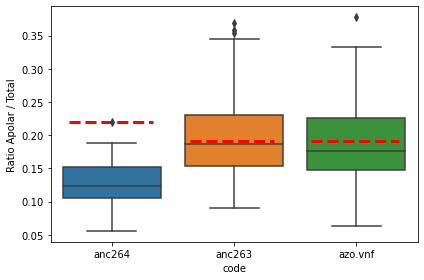

In [58]:
fig, ax = plt.subplots(1)
ax.axhline(dg_interfaces.loc['anc264']['ratio'], xmin=0.05, xmax=0.28, color='red', linestyle='--', linewidth=3)
ax.axhline(dg_interfaces.loc['anc263']['ratio'], xmin=0.38, xmax=0.61, color='red', linestyle='--', linewidth=3)
ax.axhline(dg_interfaces.loc['azov.vnf']['ratio'], xmin=0.71, xmax=0.95, color='red', linestyle='--', linewidth=3)

#ax.text(0.35, 0.72, 'GD')
#ax.text(1.35, 0.68, 'GD')
sns.boxplot(data=pd.concat([random_ratios_anc264, random_ratios_anc263, random_ratios_azov_vnf]), x='code', y='ratio', ax=ax)
ax.set_ylabel('Ratio Apolar / Total')
fig.tight_layout()
# plt.savefig('../figures/surface-apolar-ratio.png', dpi=300)

In [57]:
dg_interfaces

,polar_interface,total_interface,ratio
code,,,
azov.vnf,8,42,0.190476
anc263,8,42,0.190476
anc264,9,41,0.219512


In [69]:
def count_ocurrences(x: List[str], residue_list):
    """
    given a list, returns the number of hydrophobic residues based in the criteria
    applied in Hochberg2021

    Arguments:
    - x: List[str]
        List of aminoacids, using 3-letters code.

    Returns:
    - hydrophobic: int
    - total: int
    - ratio: float
    """
    polar = 0
    apolar = 0

    for res in x:
        if res in residue_list:
            apolar += 1
        else:
            polar += 1

    return apolar, polar + apolar, apolar / (apolar + polar)


interface_residues = pd.read_csv('../data/prolif/surface-evolution/D.subunit.csv').query(
    'interface==True')['resnum:AzoV.Vnf'].astype(pd.Int32Dtype()).to_list()


count_ocurrences(
    sasa_results.loc['B'].loc[interface_residues]['resname'].to_list(),
    ['ALA', 'PHE', 'ILE', 'LEU', 'MET', 'PRO', 'VAL', 'TRP']
)


(12, 42, 0.2857142857142857)

In [8]:
pdy.writePDB('anc264.sasa.pdb', anc264)

'anc264.sasa.pdb'